# Blackholes

Synthesizer has a collection of routines allowing us to also model the spectral energy distributions of black holes (i.e. AGN) and combine their emission with the emission of others galaxy components (i.e. stellar emission).

## Particle blackholes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unyt import Msun, yr, Angstrom

from synthesizer.sed import plot_spectra
from synthesizer.blackholes import UnifiedAGN
from synthesizer.particle import BlackHoles
from synthesizer.particle import Gas
from synthesizer import galaxy

# Set a random number seed to ensure consistent results
np.random.seed(42)

### Creating Particle Blackholes

Before generating some simple observational quantities from physical properties we first need to create a `BlackHoles` object. This object can be found in `synthesizer/particle/blackholes.py`. 

Lets create an instance of `BlackHoles` containing 4 fake black holes. To do so we can provide a number of optional keyword arguments but for now lets just provide their masses, metallicities, coordinates and accretion rates.

In [2]:
# Make fake properties
n = 10
masses = 10**np.random.uniform(low=7, high=9, size=n)  # Msun
coordinates = np.random.normal(0, 1.5, (n, 3))  # cMpc
accretion_rates = 10**np.random.uniform(low=-2, high=1, size=n)  # Msun  # Msun / yr
metallicities = np.full(n, 0.01)  

# And get the black holes object
bh = BlackHoles(masses=masses, coordinates=coordinates, accretion_rates=accretion_rates, metallicities=metallicities)

For some emission models we require an inclination. This could, in principle be calculated from the simulation, but for now we can use an in-built method to generate random inclinations:

In [3]:
bh.calculate_random_inclination()
print(bh.inclination)

[ 4.070456   29.27972977 34.98095607 24.42141286 74.58637582 32.1077994
 25.28410587 48.84264748 12.68318025 72.19772827] degree


#### Blackhole properties

On initialisation this automatically calculates a handful of properties if they are provided. While `particle.BlackHoles` need to be initialised with `masses` and `accretion_rates` for `parametric.BlackHoles` we have more flexibility (see below)


For example, if `masses` and `accretion_rates` are provided then `bolometric_luminosities` ($ L_{\rm \bullet, bol} = \epsilon_{r}\dot{M}_{\bullet}c^{2} $) are automatically calcualted. Note that the radiative efficency (`epsilon`) defaults to 0.1 but can be set to an array. 

In [4]:
bh.bolometric_luminosities

unyt_array([2.47272315e+45, 2.03052352e+44, 4.58985051e+46, 1.19796223e+46,
       3.72856297e+46, 2.73858805e+46, 3.52163705e+45, 3.30116599e+46,
       1.04357139e+44, 2.19277083e+44], 'erg/s')

In [5]:
bh.eddington_ratio

unyt_array([3.50558079e-01, 2.02695512e-03, 1.25451362e+00, 6.05049465e-01,
       1.44600210e+01, 1.06219044e+01, 2.14408546e+00, 4.86384575e-01,
       5.21142944e-03, 6.69133559e-03], '(dimensionless)')

In [6]:
print(bh)


--------------------------------------------------------------------------------
                                SUMMARY OF BLACKHOLE                                
Number of blackholes: 10 
mass: [5.61151642e+07 7.96945482e+08 2.91063591e+08 1.57513205e+08
 2.05133826e+07 2.05111042e+07 1.30667392e+07 5.39948441e+08
 1.59305226e+08 2.60702476e+08] dimensionless 
accretion_rate: [0.437 0.036 8.105 2.115 6.584 4.836 0.622 5.829 0.018 0.039] dimensionless 
accretion_rate_eddington: [3.5100e-01 2.0000e-03 1.2550e+00 6.0500e-01 1.4460e+01 1.0622e+01
 2.1440e+00 4.8600e-01 5.0000e-03 7.0000e-03] 
bolometric_luminosity: [2.47272315e+45 2.03052352e+44 4.58985051e+46 1.19796223e+46
 3.72856297e+46 2.73858805e+46 3.52163705e+45 3.30116599e+46
 1.04357139e+44 2.19277083e+44] dimensionless 
eddington_ratio: [3.5100e-01 2.0000e-03 1.2550e+00 6.0500e-01 1.4460e+01 1.0622e+01
 2.1440e+00 4.8600e-01 5.0000e-03 7.0000e-03] dimensionless 
bb_temperature: [243075.176  34528.249 221535.101 215248.013 79

In [7]:
print(bh.masses)
print(np.sum(bh.masses))

[5.61151642e+07 7.96945482e+08 2.91063591e+08 1.57513205e+08
 2.05133826e+07 2.05111042e+07 1.30667392e+07 5.39948441e+08
 1.59305226e+08 2.60702476e+08] Msun
2315684811.3644323 Msun


### Blackhole spectra and lines

Blackhole spectra (and lines) can be generated by combining the `BlackHoles` object with an emission model. An emission model translates the physical properties of the blackhole(s) (e.g. `mass`, `accretion_rate`, etc.) to an spectral energy distribution. These models are described in more detail in the associated workbook.

In [8]:
# define the emission model
grid_dir = '../../../tests/test_grid/'
emission_model = UnifiedAGN(disc_model='test_grid_agn', photoionisation_model='', grid_dir=grid_dir)

# generate the spectra
# at the moment this produces a list of dictionaries, but that's not what we want. Instead we want a n-dimensional Sed object for each component.
spectra = bh.get_spectra(emission_model)



/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


We can now examine a single component, in this case the total:

In [9]:
sed = spectra['intrinsic']
# print(sed)
print(sed.luminosity.shape)

(10, 8228)


/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


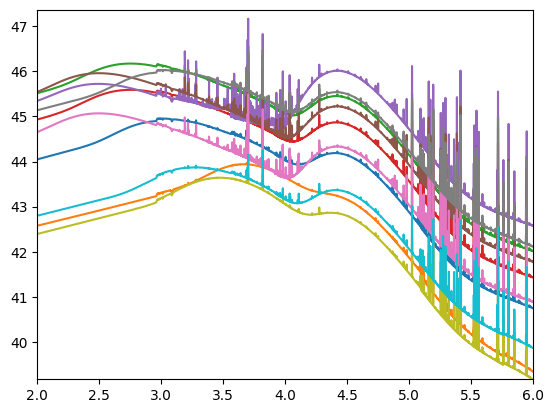

In [10]:
plt.plot(np.log10(sed.lam), np.log10(sed.luminosity.T))
plt.ylim(np.max(np.log10(sed.luminosity))-8, np.max(np.log10(sed.luminosity))+0.2)
plt.xlim([2,6])
plt.show()

#### Calculating black hole metallicity

If we want to calculate emission from the black hole we will need to know the metallicity of the emission regions surrounding the black hole. Above we could have passed an array of metallicities at instantiation but most of the time we will not know ahead of time what these values should be. Instead we can use the gas surrounding the black hole to calculate what this metallicity is. To do this we need to first create a `Galaxy` with both a `Gas` component and `BlackHoles`, again using fake data.

In [11]:
# Make fake gas properties
ngas = 200
ms = np.full(ngas, 10 ** 6.5)  # Msun
pos = np.random.normal(0, 1.5, (ngas, 3))  # cMpc
hsml = np.full(ngas, 0.75)  # cMpc
metals = np.full(ngas, 0.01)

# And make the gas object
gas = Gas(masses=ms, metallicities=metals, coordinates=pos, smoothing_lengths=hsml)

# And now create the galaxy 
galaxy = galaxy(stars=None, gas=gas, black_holes=bh)

Now we have the galaxy we can use `galaxy.calculate_black_hole_metallicity()` to calculate the black holes' metallicity. This method will find all gas particles with smoothing lengths that intersect the black hole and calculate the mass weighted average of their metallicity. If a black hole does not find any gas neighbours then a default metallicity is set instead, by default this is solar metallicity (0.012) but can be overwritten by passing a new `default_metallicity` as shown below.

In [12]:
galaxy.calculate_black_hole_metallicity(default_metallicity=0.07)
print("Z_BH =", galaxy.black_holes.metallicities)

Z_BH = [0.01 0.07 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.07]
